---
title: Classification
format:
  html:
      embed-resources: true
      code-fold: true
      cite-method: biblatex
---

## Classification Trees for Record Data

In [42]:
import pandas as pd
import sklearn.tree
import sklearn.model_selection
from sklearn.model_selection import train_test_split
apta = pd.read_csv('../../data/cleaned_data/apta_cities_cleaned.csv')
apta['Label'] = pd.qcut(apta['Trips_per_capita'], 5, labels=["Very Low", "Somewhat Low", "Average", "Somewhat High", "Very High"])
x = apta[["Population", "Area", "Fare_per_trip", "Miles_per_trip"]]
y = apta[["Label"]]
apta.head(20)

,Unnamed: 0,City,Population,Area,Cost_per_trip,Fare_per_trip,Miles_per_trip,Total_trips,Trips_per_capita,Label
0,1,"Seattle--Tacoma, WA",3544011,982.52,13.906032,1.570667,5.786344,130093841,36.708080,Very High
1,2,"Spokane, WA",447279,171.67,13.433827,0.988308,4.772569,6995911,15.641045,Very High
2,3,"Yakima, WA",133145,55.77,19.720093,1.112531,5.179168,513484,3.856577,Somewhat Low
3,4,"Eugene, OR",270179,73.49,10.851494,2.753356,3.684118,5296214,19.602612,Very High
4,5,"Portland, OR--WA",2104238,519.30,10.804361,1.025659,4.011388,56312874,26.761647,Very High
5,6,"Boise City, ID",433180,139.23,19.025372,0.744023,4.024201,1025868,2.368226,Very Low
6,7,"Anchorage, AK",249252,91.69,32.010053,13.084742,15.758352,2951428,11.841141,Somewhat High
7,8,"Longview, WA--OR",69841,35.19,22.850754,0.507897,4.141859,236475,3.385905,Somewhat Low
8,9,"Kennewick--Richland--Pasco, WA",255401,112.21,18.872776,0.707209,7.639221,2397563,9.387446,Somewhat High
9,10,"Olympia--Lacey, WA",208157,106.21,16.203378,0.122063,6.931559,3311656,15.909415,Very High


In [43]:
sorted_labels = sorted(list(apta['Label'].value_counts().index))
labels_map = {label: sorted_labels.index(label) for label in sorted_labels}
labels_map

{'Average': 0,
 'Somewhat High': 1,
 'Somewhat Low': 2,
 'Very High': 3,
 'Very Low': 4}

In [44]:
apta['Label'] = apta['Label'].apply(lambda x: labels_map[x])
feature_cols = ["Population", "Area", "Fare_per_trip", "Miles_per_trip"]
label_col = 'Label'
non_label_cols = [c for c in apta.columns if c != label_col]
X = apta[non_label_cols].copy()
y = apta[label_col]
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X, y, test_size=0.2, random_state=4000
)
X_train_num = X_train[feature_cols].copy()
X_test_num = X_test[feature_cols].copy()
X_train_num

,Population,Area,Fare_per_trip,Miles_per_trip
43,59102,24.56,1.621937,4.492402
67,72400,33.98,0.000000,1.722247
264,160578,37.70,1.667047,7.596747
41,5696125,1898.19,1.431591,4.533485
215,139338,64.47,6.457551,62.073792
...,...,...,...,...
256,875441,357.35,0.029121,4.074985
42,704327,291.83,1.665704,3.196937
166,84382,48.20,0.179002,3.675032
181,81223,44.09,6.128109,10.178216


In [12]:
import os
os.environ['PATH'] += os.pathsep + '/Users/joshsweren/anaconda3/bin/'
import graphviz

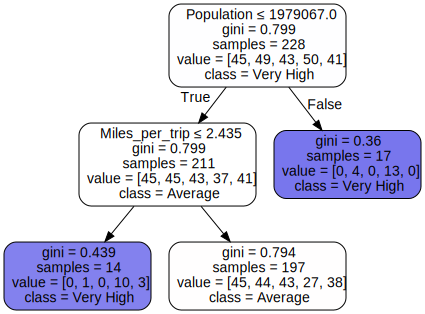

In [45]:

dtc = sklearn.tree.DecisionTreeClassifier(
    max_depth = 2,
    random_state=5000,
    #min_samples_leaf=8,
    min_impurity_decrease=0.02
)
dtc.fit(X_train_num, y_train)
y_train_pred = dtc.predict(X_train_num)
y_test_pred = dtc.predict(X_test_num)
Xy_train = pd.concat([X_train, y_train], axis=1)
Xy_train['prediction'] = y_train_pred
Xy_test = pd.concat([X_test, y_test], axis=1)
Xy_test['prediction'] = y_test_pred

def visualize_tree(dtc_object):
  dot_data = sklearn.tree.export_graphviz(dtc_object, out_file=None,
                      feature_names=X_train_num.columns,
                      class_names=list(labels_map.keys()),
                      filled=True, rounded=True,
                      special_characters=True)
  graph = graphviz.Source(dot_data)
  graph.render(outfile="test.svg")
  return graph
visualize_tree(dtc)

In [ ]:
import plotly.express as px
import plotly.graph_objs as go
import plotly.io as pio
pio.renderers.default = "notebook"
fig = px.scatter(X_train, x='log_loudness', y='danceability', color='genre',
                       hover_data=['name','artist'], template='simple_white')
fig.update_layout(title_text='All Songs', title_x=0.5)
loudness_cutoff = 1.345
dance_cutoff = 0.312
energy_cutoff = 0.777
x0 = [loudness_cutoff, loudness_cutoff]
y0 = [0.0, 1.0]
fig.add_trace(go.Scatter(name='Decision Boundary',x=x0, y=y0))
fig.add_annotation(x=loudness_cutoff - 0.3, y=0,
            text="← Quiet Songs",
            showarrow=False,
            yshift=10)
fig.add_annotation(x=loudness_cutoff + 0.3, y=0,
            text="Loud Songs →",
            showarrow=False,
            yshift=10)
fig.show()

## Classification Trees for Text Data

In [47]:
yelp = pd.read_csv('../../data/cleaned_data/total_yelp.csv')
yelp = yelp.drop(columns=['Unnamed: 0'])
import nltk
nltk.download('punkt')
nltk.download('wordnet')
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
from tqdm import tqdm
tqdm.pandas()
import string
from collections import Counter
token_counter = Counter()
from nltk.corpus import stopwords
nltk.download('stopwords')
custom_stoplemmas = [
    'be',
    'ir',
    'll',
    'nt',
    'quot',
    'rd',
    's',
    've'
]

def remove_special_chars(token):
  return token.translate(str.maketrans('', '', string.punctuation))

def remove_digits(token):
  return ''.join([c for c in token if not c.isdigit()])

def clean_review(review_text):
  review_cleaned = review_text.lower()
  review_sents = sent_tokenize(review_cleaned)
  clean_sents = []
  for cur_sent in review_sents:
    sent_tokens = word_tokenize(cur_sent)
    sent_tokens_cleaned = [t for t in sent_tokens if t not in stopwords.words('english')]
    sent_tokens_cleaned = [remove_digits(t) for t in sent_tokens_cleaned]
    sent_tokens_cleaned = [t.replace("-", " ") for t in sent_tokens_cleaned]
    sent_tokens_cleaned = [remove_special_chars(t) for t in sent_tokens_cleaned]
    sent_tokens_cleaned = [t for t in sent_tokens_cleaned if len(t) > 0]
    sent_tokens_cleaned = [lemmatizer.lemmatize(t) for t in sent_tokens_cleaned]
    sent_tokens_cleaned = [t for t in sent_tokens_cleaned if t not in custom_stoplemmas]
    token_counter.update(sent_tokens_cleaned)
    clean_sent = ' '.join(sent_tokens_cleaned)
    clean_sents.append(clean_sent)
  review_final = ". ".join(clean_sents)
  return review_final
yelp['Review_clean'] = yelp['Review'].progress_apply(clean_review)
yelp.head()

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/joshsweren/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/joshsweren/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/joshsweren/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
100%|██████████| 2434/2434 [00:32<00:00, 73.98it/s] 


,Rating,Date,Review,Review_clean
0,5,"Jul 26, 2023",I had to compliment WMATA on the shuttle servi...,compliment wmata shuttle service college park ...
1,1,"Oct 27, 2023",Since when did metro close the doors to their ...,since metro close door serviced line group peo...
2,1,"Sep 29, 2023",So many things wrong with wmata I can't even b...,many thing wrong wmata ca even begin list. one...
3,5,"Sep 23, 2023","I WFH, and WMATA has been very helpful in my m...",wfh wmata helpful mobile access thing need cit...
4,4,"Sep 18, 2022",I took the metro while visiting DC. I began at...,took metro visiting dc. began federal center p...


Text(0.5, 1.0, 'Yelp Word Cloud')

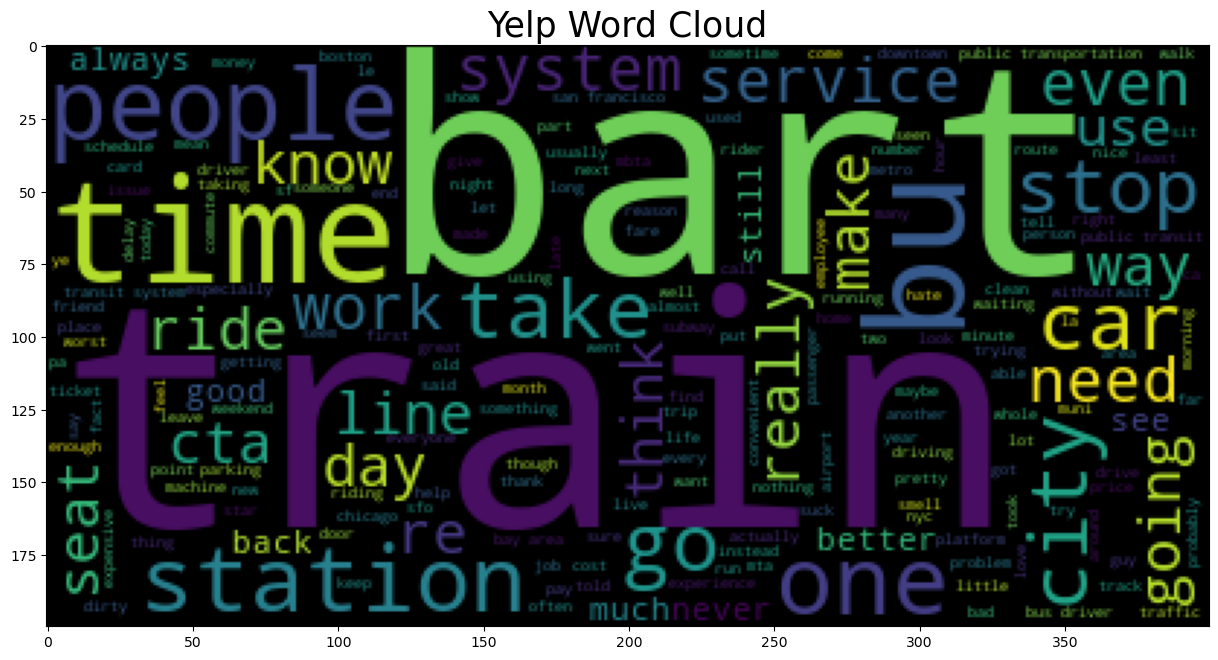

In [58]:
import wordcloud
import matplotlib.pyplot as plt
wordcloud = wordcloud.WordCloud(min_word_length = 2,max_words = 200).generate(yelp['Review_clean'].str.cat())
fig = plt.figure(figsize=(15,10))
plt.imshow(wordcloud)
plt.title('Yelp Word Cloud',fontsize = 25)